In [1]:
# Imports

import numpy as np  # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
import shutil # high-level operations on files
from tqdm import tqdm # Progress bar and status logging
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report,confusion_matrix

import cv2 # computer vision algorithms

# Importing the Keras libraries and packages
from keras import utils
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout

Using TensorFlow backend.


In [2]:
# Input data files are available in the "../input/" directory.

for dirname, _, filenames in os.walk('/kaggle'):
    print (dirname)



/kaggle
/kaggle/lib
/kaggle/lib/kaggle
/kaggle/input
/kaggle/input/real-and-fake-face-detection
/kaggle/input/real-and-fake-face-detection/real_and_fake_face
/kaggle/input/real-and-fake-face-detection/real_and_fake_face/training_fake
/kaggle/input/real-and-fake-face-detection/real_and_fake_face/training_real
/kaggle/input/real-and-fake-face-detection/real_and_fake_face_detection
/kaggle/input/real-and-fake-face-detection/real_and_fake_face_detection/real_and_fake_face
/kaggle/input/real-and-fake-face-detection/real_and_fake_face_detection/real_and_fake_face/training_fake
/kaggle/input/real-and-fake-face-detection/real_and_fake_face_detection/real_and_fake_face/training_real
/kaggle/working


In [3]:
# Configuration

DATASET_DIR = '/kaggle/input/real-and-fake-face-detection/real_and_fake_face_detection/real_and_fake_face'
TRAIN_DIR = '/kaggle/train_dataset'
TEST_DIR = '/kaggle/test_dataset'

RATE = 0.2 # splitting proportion for training and test datasets

# Parameters for Grid Search

N_EPOCHS = [20] #[20, 40, 100, 200]
OPTIMIZERS = ['adam'] #['adam', 'rmsprop', 'SGD']
DROPOUT_RATES =  [0.1, 0.2, 0.4]
LOSS_FUNCTIONS = ['binary_crossentropy']  #['sparse_categorical_crossentropy', 'kullback_leibler_divergence']    

In [4]:
os.mkdir(TRAIN_DIR)
os.mkdir(TRAIN_DIR+'/fake')
os.mkdir(TRAIN_DIR+'/real')

os.mkdir(TEST_DIR)
os.mkdir(TEST_DIR+'/fake')
os.mkdir(TEST_DIR+'/real')

Updated folder structure:

In [5]:
for dirname, _, filenames in os.walk('/kaggle'):
    print (dirname)

/kaggle
/kaggle/train_dataset
/kaggle/train_dataset/fake
/kaggle/train_dataset/real
/kaggle/lib
/kaggle/lib/kaggle
/kaggle/test_dataset
/kaggle/test_dataset/fake
/kaggle/test_dataset/real
/kaggle/input
/kaggle/input/real-and-fake-face-detection
/kaggle/input/real-and-fake-face-detection/real_and_fake_face
/kaggle/input/real-and-fake-face-detection/real_and_fake_face/training_fake
/kaggle/input/real-and-fake-face-detection/real_and_fake_face/training_real
/kaggle/input/real-and-fake-face-detection/real_and_fake_face_detection
/kaggle/input/real-and-fake-face-detection/real_and_fake_face_detection/real_and_fake_face
/kaggle/input/real-and-fake-face-detection/real_and_fake_face_detection/real_and_fake_face/training_fake
/kaggle/input/real-and-fake-face-detection/real_and_fake_face_detection/real_and_fake_face/training_real
/kaggle/working


In [7]:
# Split image files into test and training set 
# OPTION 2 (copying files into newly created folders)
files_real = os.listdir(f'{DATASET_DIR}/training_real')
files_fake = os.listdir(f'{DATASET_DIR}/training_fake')


# sample from each class to create a test set
np.random.seed(0)
files_real_test = np.random.choice(
    files_real,
    size=round(len(files_real) * RATE),
    replace=False,
    p=None)

files_real_train = list(set(files_real) - set(files_real_test)) #[file for file in files_real if file not in files_real_test] 

files_fake_test = np.random.choice(
    files_fake,
    size=round(len(files_fake) * RATE),
    replace=False,
    p=None)

files_fake_train = list(set(files_fake) - set(files_fake_test)) #[file for file in files_fake if file not in files_fake_test] 

for file in files_real_train:
    shutil.copyfile(DATASET_DIR+'/training_real/'+file, TRAIN_DIR+'/real/'+file) 

for file in files_fake_train:
    shutil.copyfile(DATASET_DIR+'/training_fake/'+file, TRAIN_DIR+'/fake/'+file) 

for file in files_real_test:
    shutil.copyfile(DATASET_DIR+'/training_real/'+file, TEST_DIR+'/real/'+file) 

for file in files_fake_test:
    shutil.copyfile(DATASET_DIR+'/training_fake/'+file, TEST_DIR+'/fake/'+file) 
    

In [8]:
train_samples = sum([len(files) for r, d, files in os.walk(TRAIN_DIR)])
test_samples = sum([len(files) for r, d, files in os.walk(TEST_DIR)])
print('Number of training images: {} \nNumber of test images: {}'.format(train_samples, test_samples))

Number of training images: 1633 
Number of test images: 408


JPEG
RGB
(600, 600)


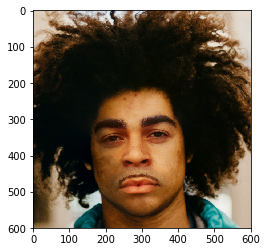

In [9]:
# load and show an image with Pillow
from PIL import Image
from matplotlib import pyplot as plt
image = Image.open('/kaggle/test_dataset/fake/hard_39_1111.jpg')
# # some details about the image
print(image.format)
print(image.mode)
print(image.size)
plt.imshow(image)

In [10]:

def get_images(path, img_shape=(64, 64)):
 
    '''
    Returns a np array of images and labels from path
    Images must be stored in path/class1, path/class2
    '''
    main_path = path
    y = []
    list = [name for name in os.listdir(main_path) if os.path.isdir(os.path.join(main_path, name))]
    print(list)
    image_collection = []
    for idx,folder in enumerate(list):
 
        label = idx
        
        sub_list = sorted(os.listdir(os.path.join(main_path,folder)))
 
        for i in tqdm(range(1, len(sub_list))):
            image_path = os.path.join(main_path, folder, sub_list[i])
            read_image = cv2.imread(image_path)
            image_resized = cv2.resize(read_image, img_shape, interpolation=cv2.INTER_AREA)
 
            image = np.float32(image_resized)
            image = cv2.normalize(image, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F) #Change alpha, beta according to the preprocessing you desire
            
            image_collection.append(image)
            
            y.append(label)
 
    y = np.array(y)
    y = utils.to_categorical(y,num_classes=len(list))
 
    return image_collection, y[:,0] 


In [11]:
# Preparing test and trainng datasets
X_train,y_train = get_images(TRAIN_DIR,img_shape=(64,64))
X_test,y_test = get_images(TEST_DIR,img_shape=(64,64))
X_train = np.array(X_train)
X_test = np.array(X_test)
# print(X_train.shape)
# print(X_train[0])
# from PIL import Image
# im = Image.fromarray(X_train[0].astype('uint8'))
# im.save("img50.jpg")


  1%|          | 5/767 [00:00<00:16, 46.91it/s]

['fake', 'real']


  5%|▍         | 9/191 [00:00<00:02, 84.36it/s]

['fake', 'real']


100%|██████████| 215/215 [00:02<00:00, 85.80it/s]


In [12]:
print('Training set', X_train.shape)
print('Test set', X_test.shape)

Training set (1631, 64, 64, 3)
Test set (406, 64, 64, 3)


We don't have too much data to train the network. 
One of possible workarounds is to use ImageDataGenerator.
On the one hand, it does allow us to generate additional examples. On the other hand, all of these examples are based on a too small dataset and the network still cannot generalize to data it was never trained on 


In [15]:
#Shuffle training examples
X_train, y_train = shuffle(X_train, y_train)

In [13]:
def build_classifier(optimizer, dropout, loss):
    classifier = Sequential() # Initialising the CNN    
    classifier.add(Conv2D(32, (3, 3), input_shape = (64, 64, 3), activation = 'relu')) 
    classifier.add(MaxPooling2D(pool_size = (2, 2))) 
    classifier.add(Dropout(dropout))
    classifier.add(Conv2D(32, (3, 3), activation = 'relu'))  
    classifier.add(MaxPooling2D(pool_size = (2, 2)))
    classifier.add(Dropout(dropout))
    classifier.add(Conv2D(32, (3, 3), activation = 'relu'))  
    classifier.add(MaxPooling2D(pool_size = (2, 2)))
    classifier.add(Dropout(dropout))
    classifier.add(Flatten())
    classifier.add(Dense(units = 128, activation = 'relu'))
    classifier.add(Dense(units = 1, activation = 'sigmoid')) #'tanh'))
    
    classifier.compile(optimizer = optimizer, loss = loss, metrics = ['accuracy'])
    
    return classifier

classifier = KerasClassifier(build_fn = build_classifier)

In [14]:
grid_parameters = {'epochs': N_EPOCHS,
                  'optimizer': OPTIMIZERS,
                  'dropout': DROPOUT_RATES,                  
                  'loss':LOSS_FUNCTIONS                        
                  }


grid_search = GridSearchCV(estimator = classifier,
                           param_grid = grid_parameters,
                           scoring = 'accuracy',
                           cv = 10)

In [15]:
%time grid_search = grid_search.fit(X_train, y_train, verbose=0)

CPU times: user 5min 44s, sys: 14.3 s, total: 5min 58s
Wall time: 5min 12s


In [18]:
import joblib
joblib.dump(grid_search.best_estimator_, 'gridsearch_cv.pkl')

['gridsearch_cv.pkl']

In [19]:
best_parameters = grid_search.best_params_
best_accuracy = grid_search.best_score_
print(best_parameters)
print(best_accuracy)

{'dropout': 0.1, 'epochs': 20, 'loss': 'binary_crossentropy', 'optimizer': 'adam'}
0.5137952176578786


In [23]:
predicted = grid_search.predict(X_test)

In [25]:

print('Confusion matrix for training set:')
print(confusion_matrix(y_train,grid_search.predict(X_train)))
print('\n')
print(classification_report(y_train,grid_search.predict(X_train)))

print('Confusion matrix  for test set:')
print(confusion_matrix(y_test,predicted))
print('\n')
print(classification_report(y_test,predicted))

Confusion matrix for training set:
[[742 122]
 [ 47 720]]


              precision    recall  f1-score   support

         0.0       0.94      0.86      0.90       864
         1.0       0.86      0.94      0.89       767

    accuracy                           0.90      1631
   macro avg       0.90      0.90      0.90      1631
weighted avg       0.90      0.90      0.90      1631

Confusion matrix  for test set:
[[125  90]
 [ 73 118]]


              precision    recall  f1-score   support

         0.0       0.63      0.58      0.61       215
         1.0       0.57      0.62      0.59       191

    accuracy                           0.60       406
   macro avg       0.60      0.60      0.60       406
weighted avg       0.60      0.60      0.60       406

